In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
from tqdm import tqdm
import torchtext
from torchtext import data
from torchtext import datasets
import spacy
import numpy as np
from pprint import pprint

spacy_en = spacy.load('en')

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Params(object):
    epochs = 5
    batch_size = 256
    embedding_size = 300
    hidden_size = 150
    learning_rate = 0.001
    dropout_fc = 0.5
P = Params()

In [3]:
def tokenizer(text): 
    return [tok.text for tok in spacy_en.tokenizer(text)]

TEXT = data.Field(sequential=True, lower=True, tokenize=tokenizer, include_lengths=True, eos_token='<eos>')
LABEL = data.LabelField()

train, val, test = torchtext.datasets.SNLI.splits(TEXT, LABEL)

In [4]:
print(train[0].__dict__)

{'premise': ['a', 'person', 'on', 'a', 'horse', 'jumps', 'over', 'a', 'broken', 'down', 'airplane', '.'], 'hypothesis': ['a', 'person', 'is', 'training', 'his', 'horse', 'for', 'a', 'competition', '.'], 'label': 'neutral'}


In [5]:
TEXT.build_vocab(train, vectors="glove.6B.300d", max_size=30000) 
LABEL.build_vocab(train)
P.vocab_size = len(TEXT.vocab)
P.classes = len(LABEL.vocab)

In [6]:
len(TEXT.vocab), len(LABEL.vocab)

(30003, 3)

In [7]:
train_iter, val_iter, test_iter = data.BucketIterator.splits((train, val, test), 
                                                   batch_size=P.batch_size, 
                                                   device=torch.device("cuda"), 
                                                   repeat=False, # Do not repeat the iterator for multiple epochs
                                                   sort_key=lambda x: len(x.premise))

In [8]:
iter(train_iter).__next__()


[torchtext.data.batch.Batch of size 256 from SNLI]
	[.premise]:('[torch.cuda.LongTensor of size 59x256 (GPU 0)]', '[torch.cuda.LongTensor of size 256 (GPU 0)]')
	[.hypothesis]:('[torch.cuda.LongTensor of size 22x256 (GPU 0)]', '[torch.cuda.LongTensor of size 256 (GPU 0)]')
	[.label]:[torch.cuda.LongTensor of size 256 (GPU 0)]

## 模型

模型部分参照了[这里](https://github.com/donghyeonk/match-lstm)。
实现了[Learning Natural Language Inference with LSTM](https://arxiv.org/pdf/1512.08849.pdf)。

记$h_j^s$，$h_k^t$分别为前提句和假设句中的词$x_j^s$、$x_k^t$在对应LSTM的输出。
$a_k^t$为对应于假设(hypothesis)中第k个词$x_k$的attention向量，通过对前提句所有词的LSTM输出加权求和得到：
$$a_k=\sum_{j=1}^{M}\alpha_{kj}h_j^s$$
其中，$\alpha_{kj}$为假设句中第k个词对应于前提句中第j个词的attention权重，可由下式计算：
$$
\alpha_{kj}=\frac{exp(e_{kj})}{\sum_{j'}exp(e_{kj'})}
$$
$$
e_{kj}=w^e\cdot tanh(W^sh_j^s+W^th_k^t+W^mh_{k-1}^m)
$$
其中，$w_e\in \Re^d$，$\cdot $为两个向量的点乘，$W^*$为要训练的权重，$h_{k-1}^m$为第三个LSTM的输出：
$$
m_k=[a_k, h_k^t]
$$
$$
h_k^m=LSTM(m_k, h_{k-1}^m, c_{k-1}^m)
$$
其中，$[\cdot ]$表示拼接操作。最后使用该LSTM最后的输出状态，使用全连接层去预测3种类别。

In [9]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class MatchLSTM(nn.Module):
    def __init__(self, config, word2vec=None):
        super().__init__()
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.dropout_fc = nn.Dropout(p=config.dropout_fc)
        
        self.word_embed = nn.Embedding(config.vocab_size, config.embedding_size, padding_idx=0, _weight=word2vec)
        if word2vec is not None:
            # 为了减少模型参数，所以词嵌入层不做训练
            self.word_embed.weight.requires_grad = False
        self.w_e = nn.Parameter(torch.Tensor(config.hidden_size))
        self.w_s = nn.Linear(config.hidden_size, config.hidden_size, bias=False)
        self.w_t = nn.Linear(config.hidden_size, config.hidden_size, bias=False)
        self.w_m = nn.Linear(config.hidden_size, config.hidden_size, bias=False)
        self.fc = nn.Linear(config.hidden_size, config.classes)
        nn.init.uniform_(self.w_e)
        nn.init.xavier_uniform_(self.w_s.weight)
        nn.init.xavier_uniform_(self.w_t.weight)
        nn.init.xavier_uniform_(self.w_m.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.uniform_(self.fc.bias)

        self.lstm_prem = nn.LSTM(config.embedding_size, config.hidden_size)
        self.lstm_hypo = nn.LSTM(config.embedding_size, config.hidden_size)
        self.lstm_match = nn.LSTMCell(2*config.hidden_size, config.hidden_size)
        

    def forward(self, premise, premise_len, hypothesis, hypothesis_len):
        # 前提：[L, B]
        prem_max_len = premise.size(0)
        # 按照长度降序，并得到原来的位置索引
        premise_len, p_idxes = premise_len.sort(dim=0, descending=True)
        # 对原来的位置索引进行排序就得到了原来的位置
        _, p_idx_unsort = torch.sort(p_idxes, dim=0, descending=False)
        # 按照长度排序后的索引，对一个批次中的所有前提重排序
        premise = premise[:, p_idxes]
        premise = self.word_embed(premise)
        # [L, B, E]
        packed_premise = pack_padded_sequence(premise, premise_len)
        h_s, _ = self.lstm_prem(packed_premise)
        h_s, _ = pad_packed_sequence(h_s)
        # [L, B, H]
        # 变回原来的位置
        h_s = h_s[:, p_idx_unsort]
        premise_len = premise_len[p_idx_unsort]
        # 这里将每个前提超出本身长度之外的部分变为0
        for batch_idx, pl in enumerate(premise_len):
            if pl != h_s.shape[0]:
                h_s[pl:, batch_idx] *= 0.

        # 假设：[L, B]
        hypo_max_len = hypothesis.size(0)
        hypothesis_len, h_idxes = hypothesis_len.sort(dim=0, descending=True)
        _, h_idx_unsort = torch.sort(h_idxes, dim=0, descending=False)
        hypothesis = hypothesis[:, h_idxes]
        hypothesis = self.word_embed(hypothesis)
        packed_hypothesis = pack_padded_sequence(hypothesis, hypothesis_len)
        h_t, _ = self.lstm_hypo(packed_hypothesis)
        h_t, _ = pad_packed_sequence(h_t)
        h_t = h_t[:, h_idx_unsort]
        hypothesis_len = hypothesis_len[h_idx_unsort]
        for batch_idx, hl in enumerate(hypothesis_len):
            if hl != h_t.shape[0]:
                h_t[hl:, batch_idx] *= 0.

        # matchLSTM
        batch_size = premise.size(1)
        h_m_k = torch.zeros((batch_size, self.config.hidden_size), device=self.device)
        c_m_k = torch.zeros((batch_size, self.config.hidden_size), device=self.device)
        h_last = torch.zeros((batch_size, self.config.hidden_size), device=self.device)
        
        attention = torch.zeros((batch_size, hypo_max_len, prem_max_len))

        for k in range(hypo_max_len):
            h_t_k = h_t[k]
            # [B, H]
            # Equation (6)
            # (prem_max_len, B)
            e_kj = torch.zeros((prem_max_len, batch_size), device=self.device)
            # 这里是对每个batch操作，所以先把w_e扩充batch_size，变为[B, 1, H]
            w_e_expand = self.w_e.expand(batch_size, self.config.hidden_size).unsqueeze(1)

            for j in range(prem_max_len):
                s_t_m = torch.tanh(self.w_s(h_s[j]) + self.w_t(h_t_k) + self.w_m(h_m_k)).unsqueeze(-1)
                # [B, H, 1]
                # batch-wise dot product
                # 这里是矩阵点乘，[B, 1, H] * [B, H, 1] = [B, 1, 1] -> [B]
                # https://discuss.pytorch.org/t/dot-product-batch-wise/9746
                e_kj[j] = torch.bmm(w_e_expand, s_t_m).view(batch_size)

            # Equation (3)
            # (prem_max_len, B)
            # 这里是对前提的每个词做softmax，所以dim=0设置长度那一维
            alpha_kj = F.softmax(e_kj, dim=0)
            # 保存attention权重
            attention[:, k, :] = alpha_kj.t()
            # Equation (2) 这里进行加权求和
            # [L, B]->[B, 1, L]
            # [L, B, H] -> [B, L, H]
            # [B, 1, L] * [B, L, H] = [B, 1, H] -> [B, H]
            a_k = torch.bmm(alpha_kj.t().unsqueeze(1), h_s.permute(1, 0, 2)).squeeze(1)

            # Equation (7)
            # [B, 2 * H]
            m_k = torch.cat((a_k, h_t_k), -1)

            # Equation (8)
            # h_m_k贯穿在整个假设句
            # [B, H]
            h_m_k, c_m_k = self.lstm_match(m_k, (h_m_k, c_m_k))

            # handle variable length sequences: hypothesis
            for batch_idx, hl in enumerate(hypothesis_len):
                if k + 1 == hl:
                    # 只保留真实长度最后的h_m_k
                    h_last[batch_idx] = h_m_k[batch_idx]

        return self.dropout_fc(self.fc(h_last)), attention

In [10]:
model = MatchLSTM(P, TEXT.vocab.vectors).to(DEVICE)
print(model)
criterion = nn.CrossEntropyLoss().to(DEVICE)
opt = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=P.learning_rate, betas=(0.9, 0.999), amsgrad=True)

MatchLSTM(
  (dropout_fc): Dropout(p=0.5)
  (word_embed): Embedding(30003, 300, padding_idx=0)
  (w_s): Linear(in_features=150, out_features=150, bias=False)
  (w_t): Linear(in_features=150, out_features=150, bias=False)
  (w_m): Linear(in_features=150, out_features=150, bias=False)
  (fc): Linear(in_features=150, out_features=3, bias=True)
  (lstm_prem): LSTM(300, 150)
  (lstm_hypo): LSTM(300, 150)
  (lstm_match): LSTMCell(300, 150)
)


In [11]:
def evaluate(model, data_iter):
    model.eval()
    torch.set_grad_enabled(False)
    correct, total = 0, 0
    for batch in data_iter:
        pred, _ = model(batch.premise[0], batch.premise[1], batch.hypothesis[0], batch.hypothesis[1])
        correct += (torch.max(pred, -1)[1].view(-1) == batch.label).float().sum()
        total += len(batch)
    return correct / total

def train():
    for epoch in range(1, P.epochs + 1):

        n_correct, n_total = 0, 0
        best_acc = -1
        bar = tqdm(total=len(train_iter))
        for batch_ix, batch in enumerate(train_iter, 1):
            model.train()
            torch.set_grad_enabled(True)

            opt.zero_grad()
            pred, _ = model(batch.premise[0], batch.premise[1], batch.hypothesis[0], batch.hypothesis[1])
            n_correct += (torch.max(pred, -1)[1].view(-1) == batch.label).sum().float()
            n_total += len(batch)
            train_acc = n_correct / n_total

            loss = criterion(pred, batch.label)
            loss.backward()
            opt.step()

            if batch_ix % 100 == 0:
                bar.update(100)
                val_acc = evaluate(model, val_iter)
                test_acc = evaluate(model, test_iter)
                if test_acc > best_acc:
                    best_acc = test_acc
                    torch.save(model.state_dict(), 'model_params.pt')
                # train_acc:0.8691|val_acc:0.8385|test_acc:0.8383
                bar.set_description('epoch:{:2d}|train_acc:{:.4f}|val_acc:{:.4f}|test_acc:{:.4f}'
                                    .format(epoch, train_acc.item(), val_acc.item(), test_acc.item()))
        bar.update(batch_ix % 100)
        bar.close()

if os.path.exists('model_params.pt'):
    model.load_state_dict(torch.load('model_params.pt'))
else:
    train()

epoch: 1|train_acc:0.5414|val_acc:0.7077|test_acc:0.7024: 100%|██████████| 2146/2146 [32:59<00:00,  1.13it/s]
epoch: 2|train_acc:0.6115|val_acc:0.7798|test_acc:0.7788: 100%|██████████| 2146/2146 [30:32<00:00,  1.27it/s]
epoch: 3|train_acc:0.6488|val_acc:0.8111|test_acc:0.8125: 100%|██████████| 2146/2146 [26:01<00:00,  1.30it/s]
epoch: 4|train_acc:0.6647|val_acc:0.8171|test_acc:0.8230: 100%|██████████| 2146/2146 [25:58<00:00,  1.29it/s]
epoch: 5|train_acc:0.6751|val_acc:0.8258|test_acc:0.8284: 100%|██████████| 2146/2146 [25:58<00:00,  1.30it/s]


In [30]:
import matplotlib.pyplot as plt
# plt.rcParams['savefig.dpi'] = 100
%matplotlib inline

def text2tensor(text_words):
    text = torch.LongTensor([TEXT.vocab.stoi[w] for w in text_words]).view(-1, 1).to(DEVICE)
    length = torch.LongTensor([text.shape[0]]).to(DEVICE)
    return text, length

def show_attention_map(premise, hypothesis, attention):
    fig, ax = plt.subplots(figsize=(4, 5), dpi=100)
    ax.set_xlabel('premise', fontsize=15)
    ax.set_ylabel('hypothesis', fontsize=15)
    ax.yaxis.set_label_position("right")
    im = plt.pcolormesh(np.flipud(attention), cmap="GnBu")
    # set ticks and labels
    ax.set_xticks(np.arange(len(premise)) + 0.5)
    ax.set_xticklabels(premise, fontsize=15)
    ax.set_yticks(np.arange(len(hypothesis)) + 0.5)
    ax.set_yticklabels(reversed(hypothesis), fontsize=15)
    # let the horizontal axes labelling appear on top
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    # rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=-45, ha="right", rotation_mode="anchor")
    plt.tight_layout()
    plt.savefig('attention.png')
    
def show_attention(model, premise, hypothesis):
    premise_words = tokenizer(premise.lower()) + ['<eos>']
    premise = text2tensor(premise_words)
    hypothesis_words = tokenizer(hypothesis.lower()) + ['<eos>']
    hypothesis = text2tensor(hypothesis_words)
    torch.set_grad_enabled(False)
    model.eval()
    pred = model(premise[0], premise[1], hypothesis[0], hypothesis[1])
    label_ix = np.argmax(pred[0].cpu().numpy())
    print(LABEL.vocab.itos[label_ix])
    attention = pred[1].squeeze(0).cpu().numpy()
    show_attention_map(premise_words, hypothesis_words, attention)

entailment
contradiction
neutral


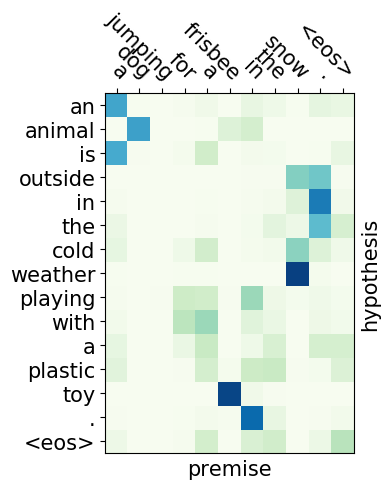

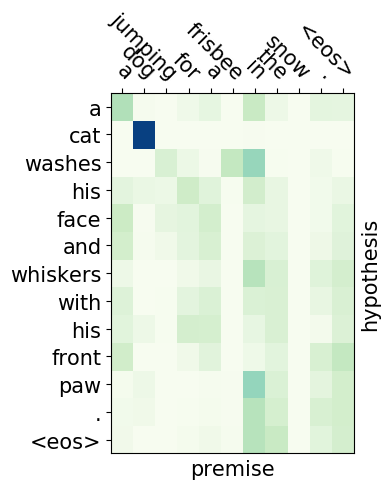

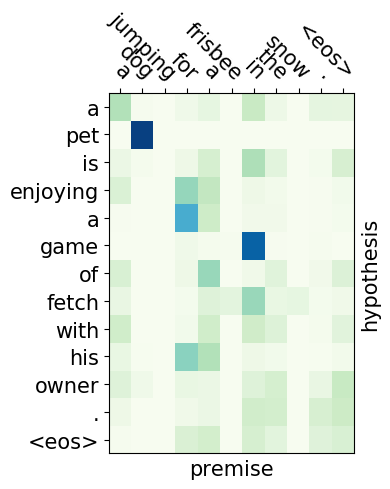

In [33]:
# Entailment
premise = 'A dog jumping for a Frisbee in the snow.'
hypothesis1 = 'An animal is outside in the cold weather playing with a plastic toy.'
# Contradiction
hypothesis2 = 'A cat washes his face and whiskers with his front paw.'
# Neutral
hypothesis3 = 'A pet is enjoying a game of fetch with his owner.'

show_attention(model, premise, hypothesis1)
show_attention(model, premise, hypothesis2)
show_attention(model, premise, hypothesis3)